This notebook compares the stream flow directions from our software and RivGraph using data from Supplement of their [journal paper](https://esurf.copernicus.org/articles/8/87/2020/esurf-8-87-2020.html).

We are going to read in the links/edges from `rivgraph` and `orinoco` and compare their directionality per segment.

The only real "tricky" part is that the edges in `rivgraph` are divided between edges so we seperate them into individual lines so we can accyurately compare them per segment.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from orinoco import (rasterize_shapes_to_array, 
                     apply_func_to_superpixels, 
                     get_array_from_features,
                     get_cropped_profile,
                     get_graph_from_edge_dataframe
                    )
from pathlib import Path
import rasterio
from shapely.geometry import LineString
import pandas as pd
from rasterio import plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors, colorbar, cm
from matplotlib.lines import Line2D
from scipy.ndimage import binary_dilation
import networkx as nx

In [2]:
site_name = 'mackenzie'

In [3]:
esurf_data = Path(f'esurf_data/{site_name}')
esurf_data.exists()

True

In [4]:
site_dir = Path(f'out/{site_name}')
site_dir.exists()

True

# Reading Rivgraph Data

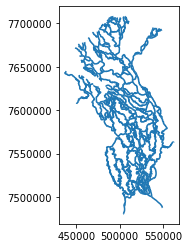

In [5]:
rivgraph_edges = gpd.read_file(esurf_data/f'{site_name.capitalize()}_links.shp')
rivgraph_edges.plot()

In [6]:
rivgraph_edges.head()

,guess,guess_alg,wid,certain_al,conn,slope,len,certain,certain_or,wid_pix,id,wid_adj,len_adj,geometry
0,"22, 22, 22, 22","4, 10, 12, 11",2504.3314474658146,4.0,"22, 26",-0.00019559170375095113,891.8376618407358,1.0,116.0,2442.37589245 2495.59612117 2522.855525 2497...,25,2504.3314474658146,891.8376618407358,"LINESTRING (483555 7691055, 483555 7691085, 48..."
1,"26, 26, 26, 26","4, 10, 12, 11",2814.3213024236084,4.0,"26, 30",-0.00024584053084469713,469.70562748477147,1.0,117.0,2523.56890138 2580.69758011 2620.83956014 2678...,29,2814.3213024236084,469.70562748477147,"LINESTRING (482805 7691355, 482805 7691385, 48..."
2,"36, 36, 36, 36","4, 10, 12, 11",1984.9632805317115,1.0,"36, 22",-0.00023683506479075207,7180.508652763333,1.0,120.0,1740. 1741.03417543 1684.28026171 1689...,35,1926.7664094258196,5104.9956672411245,"LINESTRING (488205 7686855, 488175 7686855, 48..."
3,"54, 54, 54, 54","4, 10, 12, 11",1945.6621498193706,4.0,"54, 36",-0.00024256085450335816,779.1168824543144,1.0,121.0,1920.93727123 1958.97932608 1968.14633602 1932...,55,1945.6621498193706,779.1168824543144,"LINESTRING (488745 7686405, 488715 7686405, 48..."
4,"54, 66","10, 11",628.8685630909166,6.0,"54, 66",-9.990394777862138e-05,1505.5129855222071,1.0,717.0,1920.93727123 1836.6273438 1752.36982398 1668...,69,628.8685630909166,1505.5129855222071,"LINESTRING (488745 7686405, 488775 7686435, 48..."


This is where we expand each line string within the RivGraph edges. More explicitly, a `LineString` may consist of numerous line segments and we have to expand them in to individual geometries to make our subsequent comparison.

In [7]:
def expand_linestring(geo):
    geos = [LineString([geo.coords[i], geo.coords[i+1]]) for i in range(len(geo.coords) - 1)]
    return geos

expanded_geos = rivgraph_edges.geometry.map(expand_linestring)
indices = rivgraph_edges.index.tolist()
expanded_geos.index = indices

data = [{'segment_id': index,
         'geometry': line} for index in expanded_geos.index for line in expanded_geos[index]]
df_temp = pd.DataFrame(data)

rivgraph_edges = gpd.GeoDataFrame(df_temp,
                                  geometry=df_temp.geometry,
                                  crs=rivgraph_edges.crs)

# Getting Directions for edges

Our goal is to determine the angle between the two edges using the [geometric formula](https://en.wikipedia.org/wiki/Dot_product#Definition) associated with the dot-product:

$$
\theta = \cos^{-1}\left(\frac{\mathbf x_{\textrm{RivGraph}} \cdot \mathbf  x_{\textrm{orinoco}}}{||\mathbf x_{\textrm{RivGraph}}|| \cdot ||  \mathbf  x_{\textrm{orinoco}}||}\right).
$$

We have to compute the $(x, y)$ coordinates of each edge-vector.

In [8]:
rivgraph_edges['edge_x'] = rivgraph_edges.geometry.map(lambda x: x.coords[-1][0] - x.coords[0][0])
rivgraph_edges['edge_x'][25]

-30.0

In [9]:
rivgraph_edges['edge_y'] = rivgraph_edges.geometry.map(lambda x: x.coords[-1][1] - x.coords[0][1])
rivgraph_edges['edge_y'][25]

30.0

In [10]:
orinoco_edges = gpd.read_file(site_dir/f'{site_name}_edges.geojson')
orinoco_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,width_m,geometry
0,653.264437,653.264437,0,24,0,991.827830,LINESTRING (507725.9405940594 7703901.18811881...
1,162.192384,162.192384,1,11,0,1348.479959,LINESTRING (507725.9405940594 7703901.18811881...
2,151.158641,151.158641,0,24,0,555.643031,"LINESTRING (507281.875 7704380.3125, 507176.04..."
3,159.295980,159.295980,0,24,0,566.002329,LINESTRING (507176.043956044 7704488.241758241...
4,166.451275,166.451275,0,24,0,558.937675,LINESTRING (507061.5957446808 7704599.04255319...


In [11]:
orinoco_edges['edge_y'] = orinoco_edges.geometry.map(lambda x: x.coords[1][1] - x.coords[0][1])
orinoco_edges['edge_y'][3]

110.80079494975507

In [12]:
orinoco_edges['edge_x'] = orinoco_edges.geometry.map(lambda x: x.coords[1][0] - x.coords[0][0])
orinoco_edges['edge_x'][3]

-114.4482113631093

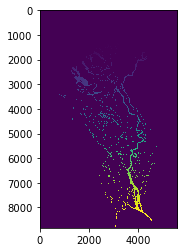

In [13]:
with rasterio.open(site_dir/f'segments_{site_name}.tif') as ds:
    segments = ds.read(1)
    profile = ds.profile
plt.imshow(segments)

Now, we rasterize each of these vector components into a raster so that we can aggregate them per segment. All pixels not intersecting a line string are given `np.nan` values.

In [14]:
rivgraph_edges_y = rasterize_shapes_to_array(rivgraph_edges.geometry, rivgraph_edges.edge_y, profile)
rivgraph_edges_x = rasterize_shapes_to_array(rivgraph_edges.geometry, rivgraph_edges.edge_x, profile)

# This portion ensures that all those pixels not touched are given `np.nan` values
rivgraph_mask = rasterize_shapes_to_array(rivgraph_edges.geometry, rivgraph_edges.shape[0] * [1], profile)
rivgraph_edges_y[~rivgraph_mask.astype(bool)] = rivgraph_edges_x[~rivgraph_mask.astype(bool)] = np.nan

In [15]:
orinoco_edges_y = rasterize_shapes_to_array(orinoco_edges.geometry, orinoco_edges.edge_y, profile)
orinoco_edges_x = rasterize_shapes_to_array(orinoco_edges.geometry, orinoco_edges.edge_x, profile)

# This portion ensures that all those pixels not touched are given `np.nan` values
orinoco_mask = rasterize_shapes_to_array(orinoco_edges.geometry, orinoco_edges.shape[0] * [1], profile)
orinoco_edges_y[~orinoco_mask.astype(bool)] = orinoco_edges_x[~orinoco_mask.astype(bool)] = np.nan

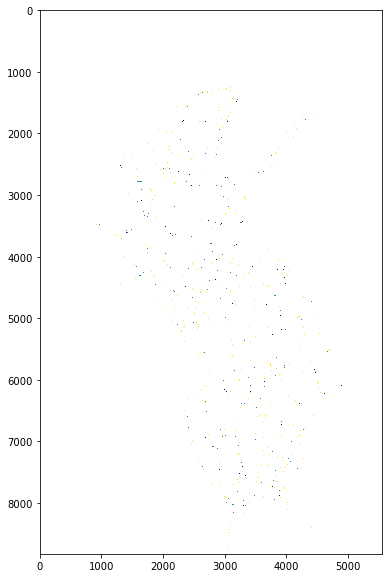

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(rivgraph_edges_y)

In [17]:
orinoco_edges_y_features = apply_func_to_superpixels(np.nanmean, segments, orinoco_edges_y)
orinoco_edges_x_features = apply_func_to_superpixels(np.nanmean, segments, orinoco_edges_x)

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:444: RuntimeWarning: Mean of empty slice
  output[i] = func(*[inp[l:h] for inp in inputs])


In [18]:
rivgraph_edges_y_features = apply_func_to_superpixels(np.nanmean, segments, rivgraph_edges_y)
rivgraph_edges_x_features = apply_func_to_superpixels(np.nanmean, segments, rivgraph_edges_x)

In [19]:
orinoco_norms = np.sqrt(orinoco_edges_y_features**2 + orinoco_edges_x_features**2)
rivgraph_norms = np.sqrt(rivgraph_edges_y_features**2 + rivgraph_edges_x_features**2)
theta_features = np.arccos((rivgraph_edges_x_features * orinoco_edges_x_features + 
                            rivgraph_edges_y_features * orinoco_edges_y_features) /
                           (orinoco_norms * rivgraph_norms)
                          )
                  
theta_arr = get_array_from_features(segments, theta_features) * 180 / np.pi

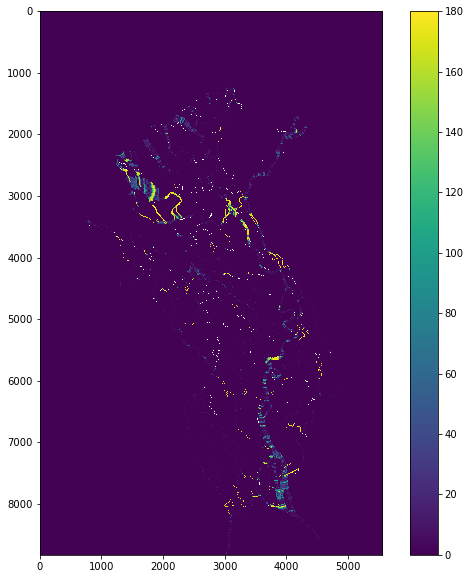

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(theta_arr)
plt.colorbar()

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


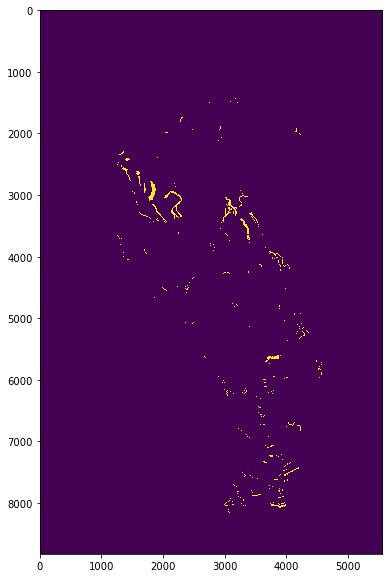

In [21]:
plt.figure(figsize=(10, 10))

angles_more_than_90 = theta_arr >= 90
plt.imshow(angles_more_than_90)


In [22]:
p = profile.copy()
p['dtype'] = 'uint8'
with rasterio.open(site_dir/'angles_more_than_90.tif', 'w', **p) as ds:
    ds.write(angles_more_than_90.astype(np.uint8), 1)
    
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(site_dir/'theta.tif', 'w', **p) as ds:
    ds.write(theta_arr.astype(np.float32), 1)

# Making Figures

In [23]:
PLOT_DIR = Path('plot/directionality')
PLOT_DIR.mkdir(exist_ok=True, parents=True)

In [24]:
with rasterio.open(site_dir/f'water_mask_{site_name}.tif') as ds:
    water_mask = ds.read(1).astype(bool)

In [25]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=25)

0.8679260580509162
0.8467650397275823


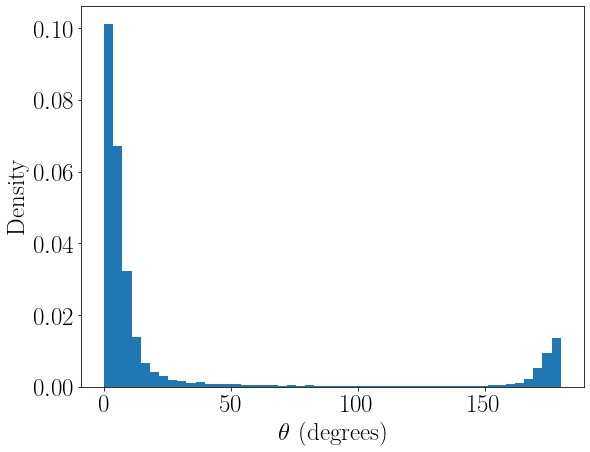

In [26]:
plt.figure(figsize=(9, 7))
theta_data = theta_features[~np.isnan(theta_features)] * 180 / np.pi
plt.hist(theta_data, 
         range=(0, 180), 
         bins=50,
         density=True)
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('Density')
print(theta_data[theta_data < 90].size / theta_data.size)
print(theta_data[theta_data < 45].size / theta_data.size)

plt.savefig(PLOT_DIR/'theta_histogram.png')

In [27]:
import scipy.stats

d = scipy.stats.describe(theta_data)
d, d.variance**.5

(DescribeResult(nobs=24668, minmax=(0.0, 180.0), mean=28.948196124679924, variance=3131.5770976495974, skewness=2.0902120140747003, kurtosis=2.583419950447584),
 55.960495866723676)

Getting the UTM zone for plotting.

In [46]:
import pyproj

srs = (pyproj.Proj(**profile['crs'])).srs
srs

'+proj=utm +zone=8 +datum=WGS84 +units=m +no_defs'

In [47]:
zone_num = srs.split('+')[2].strip().split('=')[1]
UTM_ZONE_STR = f'UTM Zone {zone_num}'
UTM_ZONE_STR

'UTM Zone 8'

# The Angle between Directions

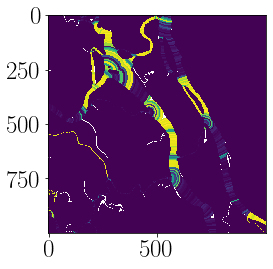

In [28]:
sy = np.s_[3_000: 4_000]
sx = np.s_[2_800: 3_800]
plt.imshow(theta_arr[sy, sx])

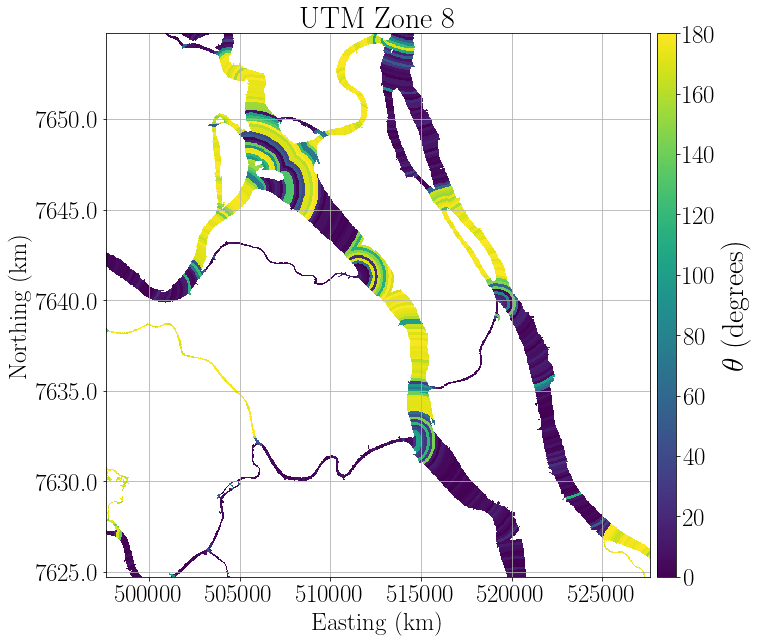

In [49]:
fig, ax = plt.subplots(figsize=(11, 10))

arr = theta_arr.copy()
arr[~water_mask] = np.nan

cropped_profile = get_cropped_profile(profile, sx, sy)
plot.show(arr[sy, sx], transform=cropped_profile['transform'], ax=ax, vmin=0, vmax=180)


cmap = 'viridis'
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3.5%', pad=0.1)

norm = colors.Normalize(vmin=0, vmax=180)
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\theta$ (degrees)', fontsize=30)

ax.grid('on')

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)

plt.savefig(PLOT_DIR/'theta_subset_1.png')

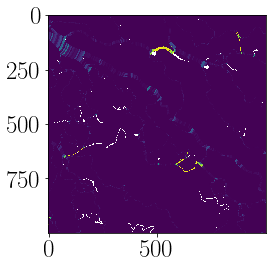

In [50]:
sy2 = np.s_[4_100: 5_100]
sx2 = np.s_[2_500: 3_500]
plt.imshow(theta_arr[sy2, sx2])

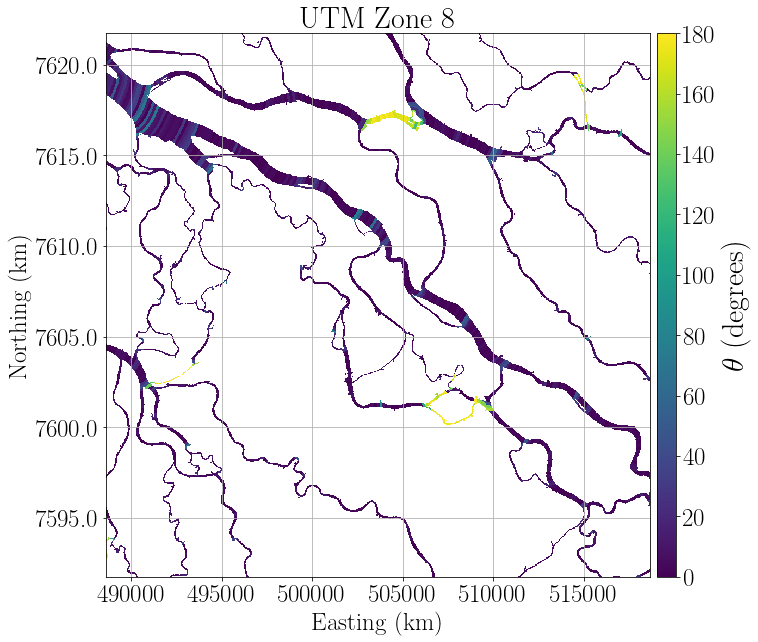

In [51]:
fig, ax = plt.subplots(figsize=(11, 10))

arr = theta_arr.copy()
arr[~water_mask] = np.nan

cropped_profile2 = get_cropped_profile(profile, sx2, sy2)
plot.show(arr[sy2, sx2], transform=cropped_profile2['transform'], ax=ax)


cmap = 'viridis'
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3.5%', pad=0.1)

norm = colors.Normalize(vmin=0, vmax=180)
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\theta$ (degrees)', fontsize=30)

ax.grid('on')

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)


plt.savefig(PLOT_DIR/'theta_subset_2.png')

In [52]:
with rasterio.open(site_dir/f'ocean_mask_{site_name}.tif') as ds:
    ocean_mask = ds.read(1)

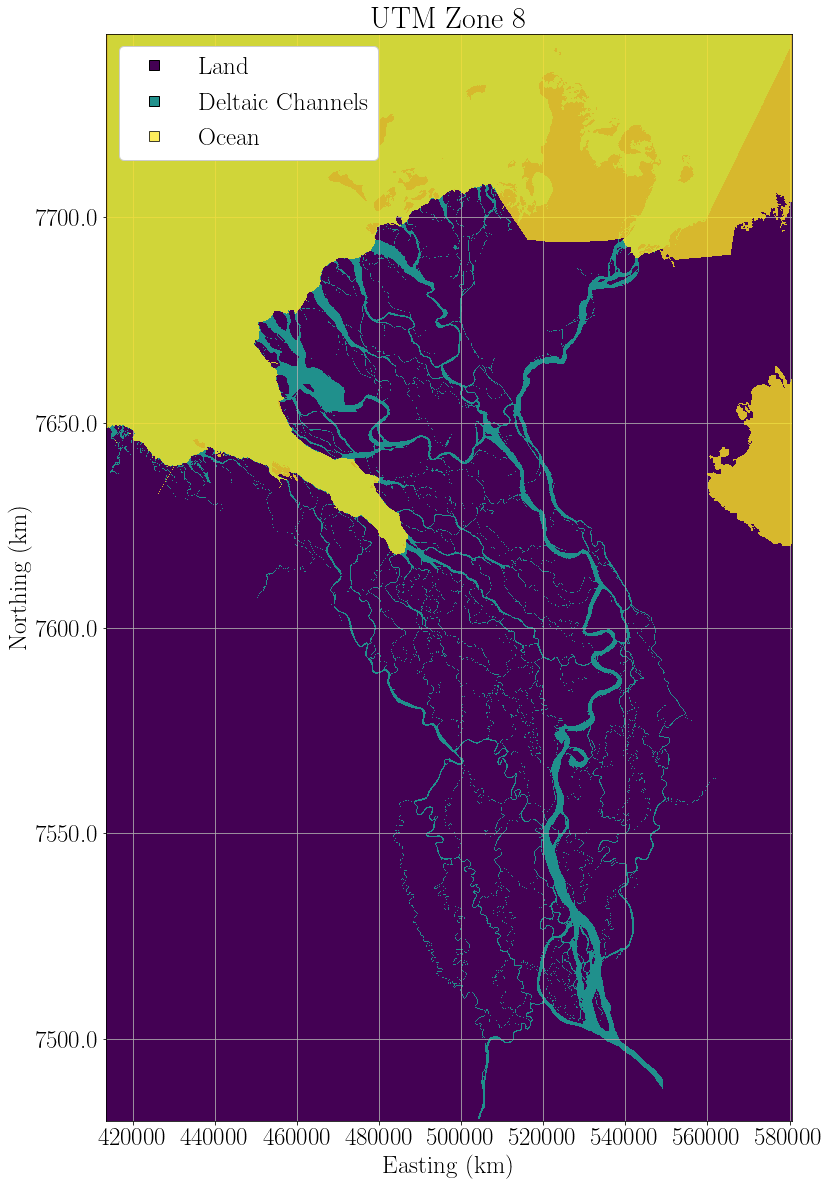

In [53]:
fig, ax = plt.subplots(figsize=(20,20))

ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

plot.show(water_mask, ax=ax, transform=profile['transform'], zorder=1,  vmin=0, vmax=2, interpolation='none')
plot.show(ocean_layer, ax=ax, transform=profile['transform'], zorder=2, cmap='viridis', vmin=0, vmax=1, alpha=.8, interpolation='none')
ax.grid('on', zorder=5)



########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 3
labels = ['Land', 'Deltaic Channels', 'Ocean']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper left', fontsize=25,  framealpha=1)


################
# Empty Colorbar
###############

# To match size of other figures

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)
cax.axis('off')

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)

plt.savefig(PLOT_DIR/'landcover_init.png')

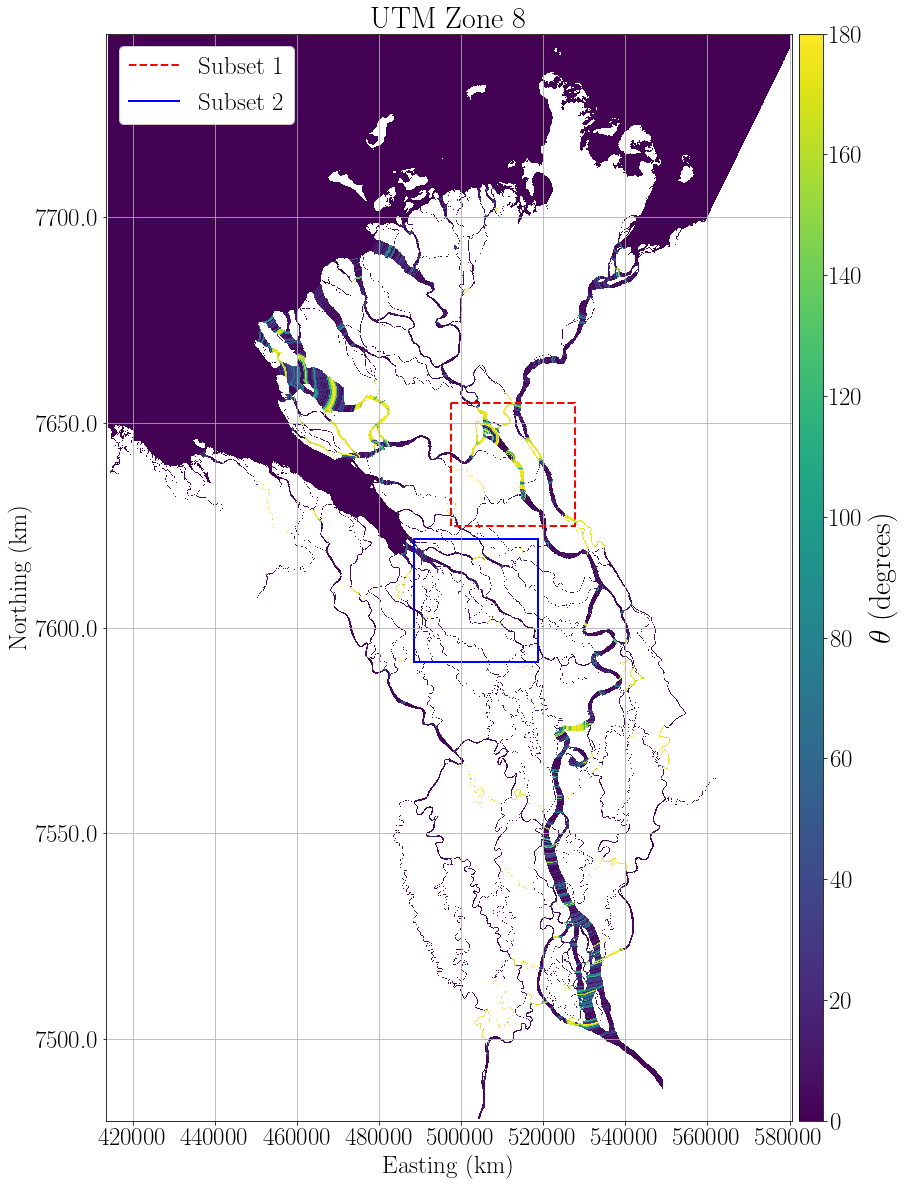

In [54]:
fig, ax = plt.subplots(figsize=(20, 20))

arr = theta_arr.copy()
arr[~water_mask] = np.nan
plot.show(arr, transform=profile['transform'], ax=ax, interpolation='none')


# Make rectangles
# mask = np.zeros(arr.shape)
# mask[sy, sx] = 1
# mask = binary_dilation(mask, iterations=20).astype(float)
# mask[sy, sx] = 0
# mask[mask == 0] = np.nan

# mask2 = np.zeros(arr.shape)
# mask2[sy2, sx2] = 1
# mask2 = binary_dilation(mask2, iterations=20).astype(float)
# mask2[sy2, sx2] = 0
# mask2[mask2 == 0] = np.nan

# plot.show(mask, transform=profile['transform'], ax=ax, cmap='Reds_r')
# plot.show(mask2, transform=profile['transform'], ax=ax, cmap='Greens_r')


# Make Colorbar
cmap = 'viridis'
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3.5%', pad=0.1)

norm = colors.Normalize(vmin=0, vmax=180)
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\theta$ (degrees)', fontsize=30)


# Create a Rectangle patch
T = profile['transform']
x0, y0 = T * (sx.start, sy.start)
x1, y1 = T * (sx.stop, sy.stop)

rect = mpatches.Rectangle((x0, y0),
                          x1 - x0,
                          y1 - y0,
                          linewidth=2,
                          edgecolor='r',
                          facecolor='none',
                          ls='--')
x0, y0 = T * (sx2.start, sy2.start)
x1, y1 = T * (sx2.stop, sy2.stop)
rect2 = mpatches.Rectangle((x0, y0),
                           x1 - x0,
                           y1 - y0,
                           linewidth=2,
                           edgecolor='blue',
                           facecolor='none',
                           ls='-')

# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect2)

ax.grid('on')


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = ([Line2D([0], 
                          [0], 
                          marker=None,
                          color='red',
                          ls = '--',
                          label='Subset 1',
                          linewidth=2,
                          markersize=10)] +
                   [Line2D([0], 
                          [0], 
                          marker=None,
                          color='blue',
                          label='Subset 2',
                          linewidth=2,
                          markersize=10)] 
                  )

ax.legend(handles=legend_elements, loc='upper left', fontsize=25, framealpha=1)

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)


plt.savefig(PLOT_DIR/'theta_full_area.png')

# The Actual Directions

In [55]:
T = profile['transform']
x0, y0 = T * (sx.start, sy.start)
x1, y1 = T * (sx.stop, sy.stop)

edges_subset = orinoco_edges.cx[x0:x1, y0: y1]
edges_subset_temp = edges_subset.copy()
counts = edges_subset_temp.groupby(['segment_id']).size().reset_index(name='counts')
edges_subset_temp = pd.merge(edges_subset_temp, counts, on='segment_id')


edges_subset_temp = edges_subset_temp[edges_subset_temp.counts > 10].copy()

edges_subset_arrow = edges_subset_temp.groupby('segment_id').apply(lambda x: x.iloc[len(x)// 2]).reset_index(drop=True)

chanG_subset = get_graph_from_edge_dataframe(edges_subset)
chanG_subset_arrow = get_graph_from_edge_dataframe(edges_subset_arrow)

H = chanG_subset.copy()
H_arrow = chanG_subset_arrow.copy()

pos_r = {node: node for node in chanG_subset.nodes()}

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/orinoco/nx_tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df['head'] = head.values
/Users/cmarshak/anaconda3/lib/python3.7/site-packages/orinoco/nx_tools.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df['tail'] = tail.values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/cmarshak/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/cmarshak/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


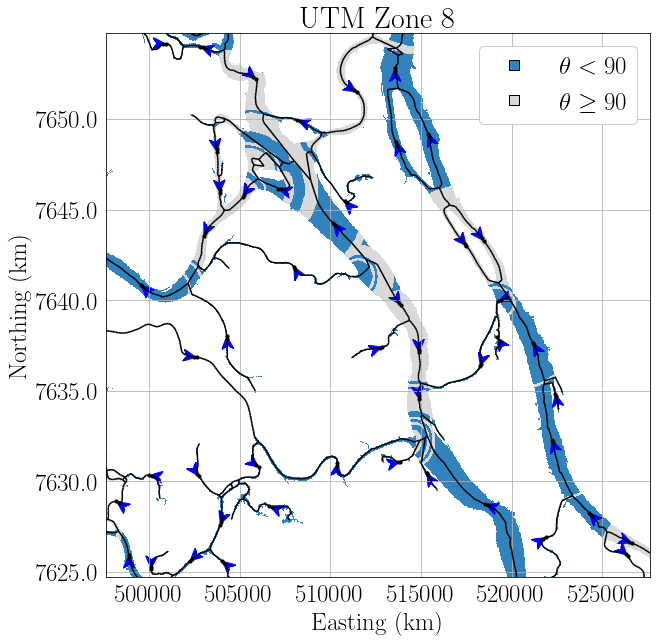

In [56]:
fig, ax = plt.subplots(figsize=(11, 10))

ax.set_xlim((x0, x1))
ax.set_ylim((y1, y0))

cmap = 'tab20c'

X = angles_more_than_90[sy, sx].astype(float)
X[~water_mask[sy, sx]] = np.nan
plot.show(X, transform=cropped_profile['transform'], ax=ax, alpha=1, cmap=cmap)
edges_subset.plot(ax=ax, edgecolor='black')


nx.draw(H_arrow, 
        pos=pos_r, 
        node_size=10,
        arrows=True,
        arrowstyle="fancy",
        arrowsize=28,
        ax=ax,
        node_color=(0, 0, 0, 0),
        edge_color='blue', zorder=1)




ax.set_axis_on()
ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)
########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 2
labels = [r'$\theta < 90$', r'$\theta \geq 90$']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper right', fontsize=25,  framealpha=1)

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)


plt.savefig(PLOT_DIR/'network_subset_1_orinococo.png')

In [57]:
edges_subset = rivgraph_edges.cx[x0:x1, y0: y1]
edges_subset_temp = edges_subset.copy()
counts = edges_subset_temp.groupby(['segment_id']).size().reset_index(name='counts')
edges_subset_temp = pd.merge(edges_subset_temp, counts, on='segment_id')


edges_subset_temp = edges_subset_temp[edges_subset_temp.counts > 10].copy()

edges_subset_arrow = edges_subset_temp.groupby('segment_id').apply(lambda x: x.iloc[len(x) // 2]).reset_index(drop=True)

chanG_subset = get_graph_from_edge_dataframe(edges_subset)
chanG_subset_arrow = get_graph_from_edge_dataframe(edges_subset_arrow)

H = chanG_subset.copy()
H_arrow = chanG_subset_arrow.copy()

pos_r = {node: node for node in chanG_subset.nodes()}

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


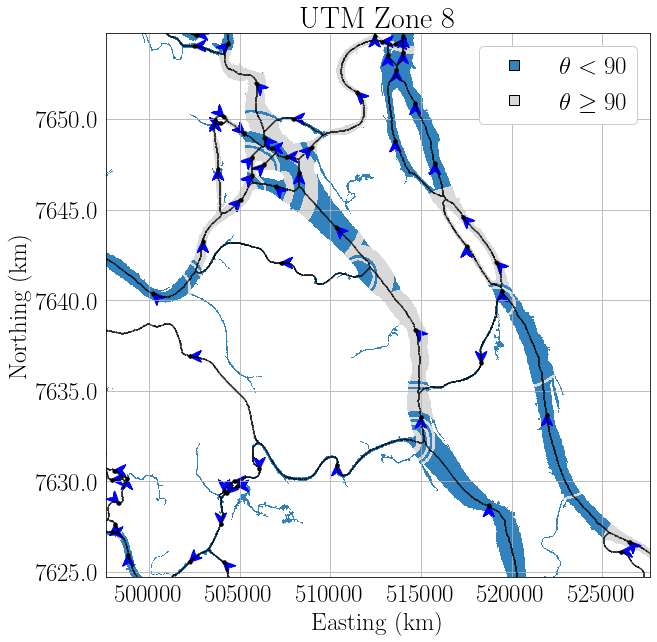

In [58]:
fig, ax = plt.subplots(figsize=(11, 10))

ax.set_xlim((x0, x1))
ax.set_ylim((y1, y0))

X = angles_more_than_90[sy, sx].astype(float)
X[~water_mask[sy, sx]] = np.nan

cmap = 'tab20c'
plot.show(X, transform=cropped_profile['transform'], ax=ax, alpha=1, cmap=cmap)
edges_subset.plot(ax=ax, edgecolor='black')

nx.draw(H_arrow, 
        pos=pos_r, 
        node_size=10,
        arrows=True,
        arrowstyle="fancy",
        arrowsize=28,
        ax=ax,
        node_color=(0, 0, 0, 0),
        edge_color='blue')


ax.set_axis_on()
ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)

########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 2
labels = [r'$\theta < 90$', r'$\theta \geq 90$']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper right', fontsize=25,  framealpha=1)

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)

plt.savefig(PLOT_DIR/'network_subset_1_rivgraph.png')

In [59]:
T = profile['transform']
x0, y0 = T * (sx2.start, sy2.start)
x1, y1 = T * (sx2.stop, sy2.stop)

edges_subset = orinoco_edges.cx[x0:x1, y0: y1]
edges_subset_temp = edges_subset.copy()
counts = edges_subset_temp.groupby(['segment_id']).size().reset_index(name='counts')
edges_subset_temp = pd.merge(edges_subset_temp, counts, on='segment_id')


edges_subset_temp = edges_subset_temp[edges_subset_temp.counts > 10].copy()

edges_subset_arrow = edges_subset_temp.groupby('segment_id').apply(lambda x: x.iloc[len(x)// 2]).reset_index(drop=True)

chanG_subset = get_graph_from_edge_dataframe(edges_subset)
chanG_subset_arrow = get_graph_from_edge_dataframe(edges_subset_arrow)

H = chanG_subset.copy()
H_arrow = chanG_subset_arrow.copy()

pos_r = {node: node for node in chanG_subset.nodes()}

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


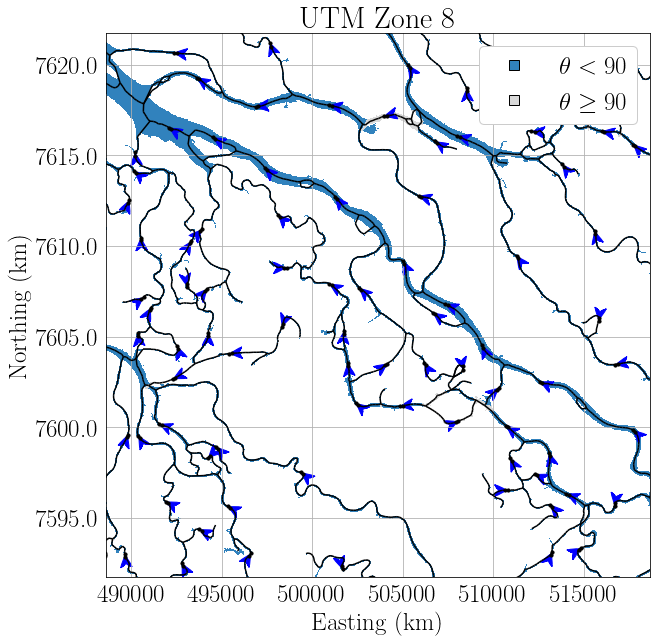

In [60]:
fig, ax = plt.subplots(figsize=(11, 10))

ax.set_xlim((x0, x1))
ax.set_ylim((y1, y0))

cmap = 'tab20c'

X2 = angles_more_than_90[sy2, sx2].astype(float)
X2[~water_mask[sy2, sx2]] = np.nan
plot.show(X2, transform=cropped_profile2['transform'], ax=ax, alpha=1, cmap=cmap)
edges_subset.plot(ax=ax, edgecolor='black')


nx.draw(H_arrow, 
        pos=pos_r, 
        node_size=10,
        arrows=True,
        arrowstyle="fancy",
        arrowsize=28,
        ax=ax,
        node_color=(0, 0, 0, 0),
        edge_color='blue', zorder=1)




ax.set_axis_on()
ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)
########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 2
labels = [r'$\theta < 90$', r'$\theta \geq 90$']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper right', fontsize=25,  framealpha=1)

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)


plt.savefig(PLOT_DIR/'network_subset_2_orinococo.png')

In [61]:
edges_subset = rivgraph_edges.cx[x0:x1, y0: y1]
edges_subset_temp = edges_subset.copy()
counts = edges_subset_temp.groupby(['segment_id']).size().reset_index(name='counts')
edges_subset_temp = pd.merge(edges_subset_temp, counts, on='segment_id')


edges_subset_temp = edges_subset_temp[edges_subset_temp.counts > 10].copy()

edges_subset_arrow = edges_subset_temp.groupby('segment_id').apply(lambda x: x.iloc[len(x)//2]).reset_index(drop=True)

chanG_subset = get_graph_from_edge_dataframe(edges_subset)
chanG_subset_arrow = get_graph_from_edge_dataframe(edges_subset_arrow)

H = chanG_subset.copy()
H_arrow = chanG_subset_arrow.copy()

pos_r = {node: node for node in chanG_subset.nodes()}

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


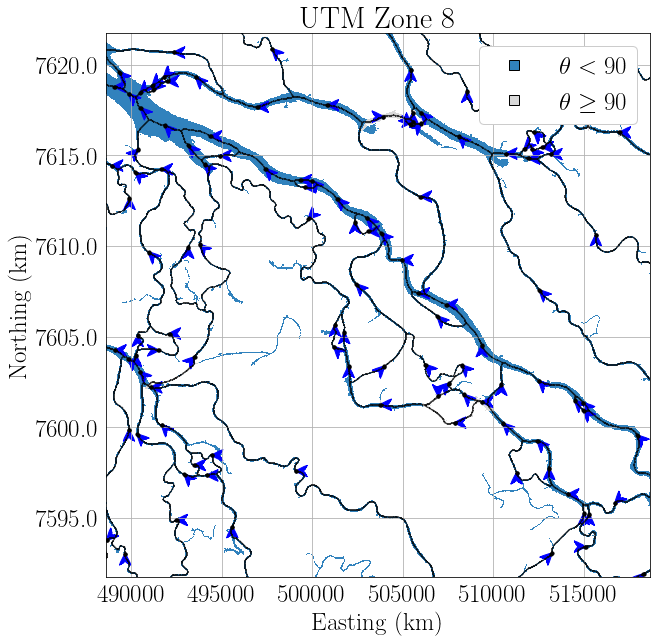

In [62]:
fig, ax = plt.subplots(figsize=(11, 10))

ax.set_xlim((x0, x1))
ax.set_ylim((y1, y0))

X2 = angles_more_than_90[sy2, sx2].astype(float)
X2[~water_mask[sy2, sx2]] = np.nan

cmap = 'tab20c'
plot.show(X2, transform=cropped_profile2['transform'], ax=ax, alpha=1, cmap=cmap)
edges_subset.plot(ax=ax, edgecolor='black')

nx.draw(H_arrow, 
        pos=pos_r, 
        node_size=10,
        arrows=True,
        arrowstyle="fancy",
        arrowsize=28,
        ax=ax,
        node_color=(0, 0, 0, 0),
        edge_color='blue')


ax.set_axis_on()
ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)

########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 2
labels = [r'$\theta < 90$', r'$\theta \geq 90$']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper right', fontsize=25,  framealpha=1)

#############
# Axes Labels
#############
ax.set_title(UTM_ZONE_STR)

ax.set_ylabel('Northing (km)')
ax.set_xlabel('Easting (km)')

# meters --> km along axes
# from this post: https://stackoverflow.com/a/27575514
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.yaxis.set_major_formatter(yfmt)


plt.savefig(PLOT_DIR/'network_subset_2_rivgraph.png')